**Курсовой проект для курса "Python для Data Science".**

Построить модель для предсказания цен на недвижимость (квартиры). С помощью полученной модели предсказать цены для квартир

**Описания полей датасета по недвижимости:**
*   Id - идентификационный номер квартиры,
*   DistrictId - идентификационный номер района,
*   Rooms - количество комнат,
*   Square - площадь,
*   LifeSquare - жилая площадь,
*   KitchenSquare - площадь кухни,
*   Floor - этаж,
*   HouseFloor - количество этажей в доме,
*   HouseYear - год постройки дома,
*   Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности,
*   Social_1, Social_2, Social_3 - социальные показатели местности,
*   Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья,
*   Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров,
*   Price - цена квартиры.

In [726]:
# загрузка библиотек

import pandas as pd
import numpy as np
import random

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error as mae
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


In [727]:
import warnings
warnings.filterwarnings("ignore")

In [728]:
# импорт файлов

df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [729]:
# выведем на экран 10 случайных записей, убедимся в успешном импорте тренировочных данных и примерно поймем с чем предстоить работать

df.sample(10)

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
5728   9135         101    2.0   57.485461   36.105040            7.0      2   
2481   5074          61    1.0   45.266911   23.601067            8.0      5   
189    3035          94    2.0   47.802228   32.542126            6.0      5   
8671    268          21    3.0   76.706022   45.984712            8.0      3   
4937   1469           8    2.0   58.087440   30.829875           11.0     15   
8824   7496          30    1.0  117.370746  102.187199            6.0     14   
2961   4705          99    3.0   69.982453   43.516284            9.0      4   
9550   6424          80    2.0   45.280191   30.982923            6.0     10   
2650   1783          52    2.0   65.347100   64.312292            1.0      5   
6880  13610           6    1.0   52.815340         NaN            1.0      5   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
5728         5.0       1960   0.225825         A         B        41   
2481        12.0       1978   0.300323         B         B        52   
189         12.0       1975   0.521867         B         B        25   
8671        17.0       2005   0.034331         B         B        25   
4937        16.0       1982   0.458174         B         A        26   
8824        40.0       2011   0.000078         B         B        22   
2961        14.0       1978   0.033494         B         B        66   
9550         9.0       1977   0.000000         B         B        39   
2650        17.0       1977   0.371149         B         B        34   
6880        17.0       1977   0.243205         B         B         5   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
5728      6558         7        1548.0            3        2       B   
2481     10311         6           NaN            1        9       B   
189       6149         0           NaN            0        0       B   
8671      5487         3           NaN            0        4       B   
4937      4439         1        1130.0            1        5       B   
8824      6398       141        1046.0            3       23       B   
2961     10573         1        1322.0            3        8       B   
9550      8647         0         810.0            0        5       B   
2650      7065         1         750.0            2        5       B   
6880      1564         0         540.0            0        0       B   

              Price  
5728  240772.951572  
2481  190428.710341  
189   162335.014034  
8671  371016.422830  
4937  227600.961929  
8824  521829.550445  
2961  239422.808920  
9550  175882.154676  
2650  164665.082415  
6880  156526.505875

In [730]:
# проверим одинаковое ли кол-во признаков в тренировочном и тестовом датасетах (за исключением признака Price)

df.shape[1]-1 == test.shape[1]

True

In [731]:
df.describe()

Id    DistrictId         Rooms        Square   LifeSquare  \
count  10000.00000  10000.000000  10000.000000  10000.000000  7887.000000   
mean    8383.40770     50.400800      1.890500     56.315775    37.199645   
std     4859.01902     43.587592      0.839512     21.058732    86.241209   
min        0.00000      0.000000      0.000000      1.136859     0.370619   
25%     4169.50000     20.000000      1.000000     41.774881    22.769832   
50%     8394.50000     36.000000      2.000000     52.513310    32.781260   
75%    12592.50000     75.000000      2.000000     65.900625    45.128803   
max    16798.00000    209.000000     19.000000    641.065193  7480.592129   

       KitchenSquare         Floor    HouseFloor     HouseYear     Ecology_1  \
count   10000.000000  10000.000000  10000.000000  1.000000e+04  10000.000000   
mean        6.273300      8.526700     12.609400  3.990166e+03      0.118858   
std        28.560917      5.241148      6.775974  2.005003e+05      0.119025   
min         0.000000      1.000000      0.000000  1.910000e+03      0.000000   
25%         1.000000      4.000000      9.000000  1.974000e+03      0.017647   
50%         6.000000      7.000000     13.000000  1.977000e+03      0.075424   
75%         9.000000     12.000000     17.000000  2.001000e+03      0.195781   
max      2014.000000     42.000000    117.000000  2.005201e+07      0.521867   

           Social_1      Social_2      Social_3  Healthcare_1   Helthcare_2  \
count  10000.000000  10000.000000  10000.000000   5202.000000  10000.000000   
mean      24.687000   5352.157400      8.039200   1142.904460      1.319500   
std       17.532614   4006.799803     23.831875   1021.517264      1.493601   
min        0.000000    168.000000      0.000000      0.000000      0.000000   
25%        6.000000   1564.000000      0.000000    350.000000      0.000000   
50%       25.000000   5285.000000      2.000000    900.000000      1.000000   
75%       36.000000   7227.000000      5.000000   1548.000000      2.000000   
max       74.000000  19083.000000    141.000000   4849.000000      6.000000   

            Shops_1          Price  
count  10000.000000   10000.000000  
mean       4.231300  214138.857399  
std        4.806341   92872.293865  
min        0.000000   59174.778028  
25%        1.000000  153872.633942  
50%        3.000000  192269.644879  
75%        6.000000  249135.462171  
max       23.000000  633233.466570

In [732]:
# выведем информацию о типе данных и проверим наличие пропусков

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Датасет содержит три категориальных признака (Ecology_2, Ecology_3, Shops_2).
По двум признакам есть пропущенные значения (LifeSquare, Healthcare_1).

In [733]:
# введем переменную obj_features для дальнейшей работы с категориальными признаками

obj_features = df.select_dtypes(include='object').columns
obj_features

Index(['Ecology_2', 'Ecology_3', 'Shops_2'], dtype='object')

In [734]:
# посмотрим на кол-во уникальных значений категориальных признаков

for column in obj_features:
    print('{}\n'.format(df[column].value_counts()))

B    9903
A      97
Name: Ecology_2, dtype: int64

B    9725
A     275
Name: Ecology_3, dtype: int64

B    9175
A     825
Name: Shops_2, dtype: int64



In [735]:
# Так как признаки принимают всего два значения, заменим их на бинарные признаки.

def obj_to_bool (columns, df):
    for column in columns:
        unique_true = df[column].unique()[1]
        df[column]  = df[column] == unique_true

obj_to_bool(obj_features, df)

In [736]:
for column in obj_features:
    print('{}\n'.format(df[column].value_counts()))

False    9903
True       97
Name: Ecology_2, dtype: int64

False    9725
True      275
Name: Ecology_3, dtype: int64

False    9175
True      825
Name: Shops_2, dtype: int64



Количество значений не изменилось, значит преобразование сделано правильно.

In [737]:
# признак Healthcare_1 содержит очень много пропущенных значений. Не будем учитывать этот признак

df.drop(['Healthcare_1'], axis=1, inplace=True)

In [738]:
# найдём долю жилой площади от общей по средним значениям и заполним пропущенные значения в столбце LifeSquare

square_mean_values = df[['Square', 'LifeSquare']].dropna().mean()
square_coeff = square_mean_values[1] / square_mean_values[0]
square_coeff

0.6734886047420247

In [739]:
def fill_life_square(df, coeff):
    df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['Square'] * coeff

fill_life_square(df, square_coeff)

In [740]:
# смотрим что получилось

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     10000 non-null  float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  bool   
 11  Ecology_3      10000 non-null  bool   
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  bool   
 18  Price  

In [741]:
df.describe()

Id    DistrictId         Rooms        Square    LifeSquare  \
count  10000.00000  10000.000000  10000.000000  10000.000000  10000.000000   
mean    8383.40770     50.400800      1.890500     56.315775     37.928033   
std     4859.01902     43.587592      0.839512     21.058732     76.927395   
min        0.00000      0.000000      0.000000      1.136859      0.370619   
25%     4169.50000     20.000000      1.000000     41.774881     24.836514   
50%     8394.50000     36.000000      2.000000     52.513310     33.626900   
75%    12592.50000     75.000000      2.000000     65.900625     45.345463   
max    16798.00000    209.000000     19.000000    641.065193   7480.592129   

       KitchenSquare         Floor    HouseFloor     HouseYear     Ecology_1  \
count   10000.000000  10000.000000  10000.000000  1.000000e+04  10000.000000   
mean        6.273300      8.526700     12.609400  3.990166e+03      0.118858   
std        28.560917      5.241148      6.775974  2.005003e+05      0.119025   
min         0.000000      1.000000      0.000000  1.910000e+03      0.000000   
25%         1.000000      4.000000      9.000000  1.974000e+03      0.017647   
50%         6.000000      7.000000     13.000000  1.977000e+03      0.075424   
75%         9.000000     12.000000     17.000000  2.001000e+03      0.195781   
max      2014.000000     42.000000    117.000000  2.005201e+07      0.521867   

           Social_1      Social_2      Social_3   Helthcare_2       Shops_1  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean      24.687000   5352.157400      8.039200      1.319500      4.231300   
std       17.532614   4006.799803     23.831875      1.493601      4.806341   
min        0.000000    168.000000      0.000000      0.000000      0.000000   
25%        6.000000   1564.000000      0.000000      0.000000      1.000000   
50%       25.000000   5285.000000      2.000000      1.000000      3.000000   
75%       36.000000   7227.000000      5.000000      2.000000      6.000000   
max       74.000000  19083.000000    141.000000      6.000000     23.000000   

               Price  
count   10000.000000  
mean   214138.857399  
std     92872.293865  
min     59174.778028  
25%    153872.633942  
50%    192269.644879  
75%    249135.462171  
max    633233.466570

In [742]:
df_num_features = df.select_dtypes(include=['float64', 'int64'])\
    .drop(['Id', 'DistrictId'], axis=1)

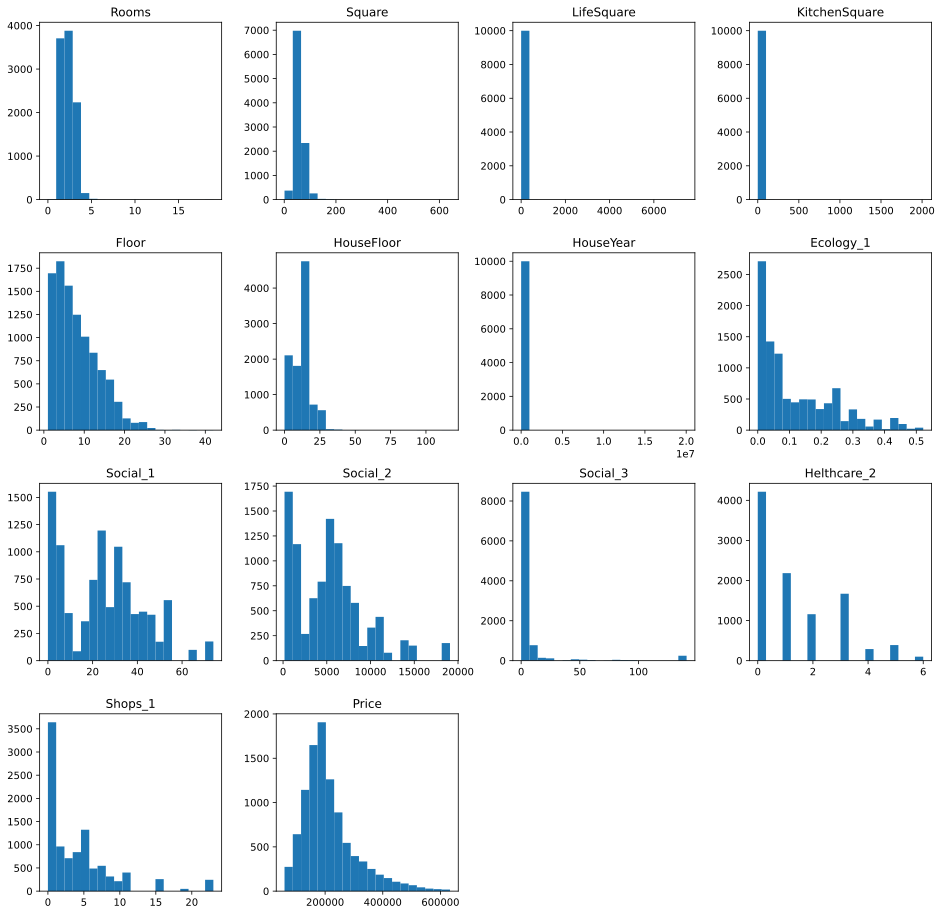

In [743]:
df_num_features.hist(figsize=(16,16), bins=20, grid=False);

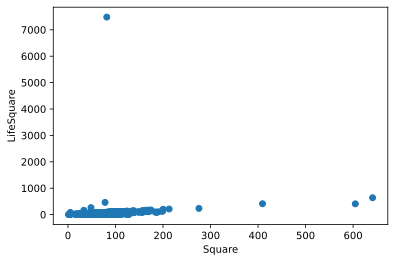

In [744]:
# для визуализации выбросов создадим функцию, показывающую отношение двух признаков. Проверим отношение LifeSquare и Square

def draw_scatter(column_x, column_y, df):
    plt.scatter(df[column_x], df[column_y])
    plt.xlabel(column_x)
    plt.ylabel(column_y)
    plt.show()  

draw_scatter('Square', 'LifeSquare', df)

In [745]:
# как видно выше у LifeSquare и Square есть выбросы, создадим функцию для их очистки. Почистим LifeSquare и Square от выбросов

def drop_by_IQ(column, df):
    IQ=df[column].describe()['75%']-df[column].describe()['25%']
    low_border=df[column].describe()['25%']-IQ*1.5
    high_border=df[column].describe()['75%']+IQ*1.5
    
    print('For column {}\n\tIQ:\t{}\n\tLOW:\t{}\n\tHIGH:\t{}\n'.format(column, IQ, low_border, high_border))
    
    size_before = df[column].size
    df.drop(df[(df[column]<low_border)|(df[column]>high_border)].index, axis=0, inplace=True)    
    size_after = df[column].size
    
    lost_percentage = (size_before - size_after) * 100 / size_before 
    print('Lost {}% of data.'.format('%0.2f' % lost_percentage))

drop_by_IQ('Square', df)
drop_by_IQ('LifeSquare', df)

For column Square
	IQ:	24.125744426186976
	LOW:	5.586264180189367
	HIGH:	102.08924188493728

Lost 2.42% of data.
For column LifeSquare
	IQ:	20.230855228785558
	LOW:	-5.813630654314267
	HIGH:	75.10979026082796

Lost 2.19% of data.


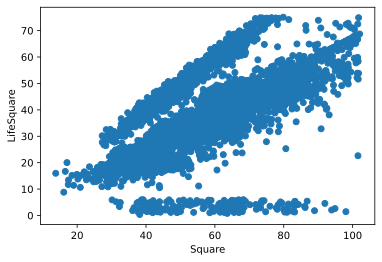

In [746]:
# смотрим что вышло

draw_scatter('Square', 'LifeSquare', df)

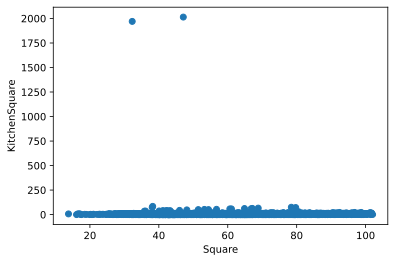

In [747]:
# смотрим выбросы дальше

draw_scatter('Square', 'KitchenSquare', df)

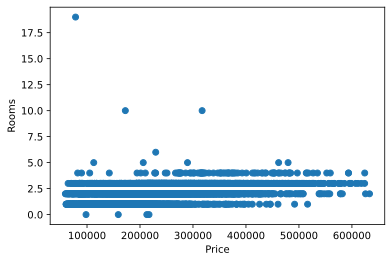

In [748]:
draw_scatter('Price', 'Rooms', df)

In [749]:
# удалим выбросы

drop_by_IQ('KitchenSquare', df)
drop_by_IQ('Rooms', df)
drop_by_IQ('Social_3', df)

For column KitchenSquare
	IQ:	8.0
	LOW:	-11.0
	HIGH:	21.0

Lost 0.32% of data.
For column Rooms
	IQ:	1.0
	LOW:	-0.5
	HIGH:	3.5

Lost 1.06% of data.
For column Social_3
	IQ:	5.0
	LOW:	-7.5
	HIGH:	12.5

Lost 8.66% of data.


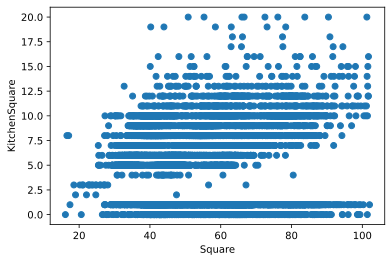

In [750]:
# смотрим что вышло

draw_scatter('Square', 'KitchenSquare', df)

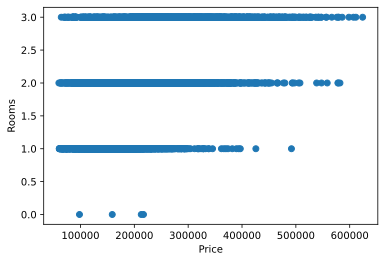

In [751]:
draw_scatter('Price', 'Rooms', df)

Ну вот, намного красивей стало) главное чтоб не навредило

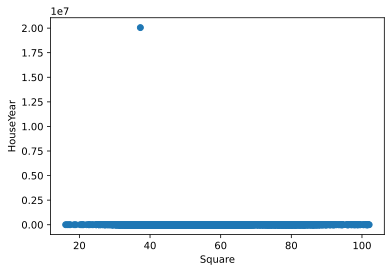

In [752]:
# еще проверим HouseYear, тоже есть подозрения на выброс

draw_scatter('Square', 'HouseYear', df)

In [753]:
# признак HouseYear так же содержит выпадающие значения. Обработаем их, заполнив средним значением.

mean_year = np.round(df.loc[df['HouseYear'] <= 2022, 'HouseYear'].mean())
mean_year

1985.0

In [754]:
df.loc[df['HouseYear'] > 2022, 'HouseYear'] = mean_year

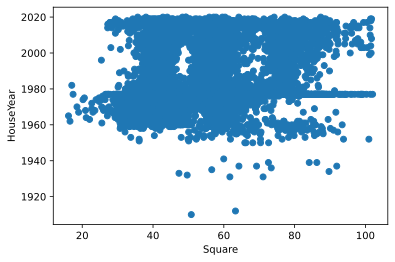

In [755]:
# смотрим что вышло

draw_scatter('Square', 'HouseYear', df)

In [756]:
# ещё раз взглянем на получившийся датасет

df_num_features = df.select_dtypes(include=['float64', 'int64'])\
    .drop(['Id', 'DistrictId'], axis=1)

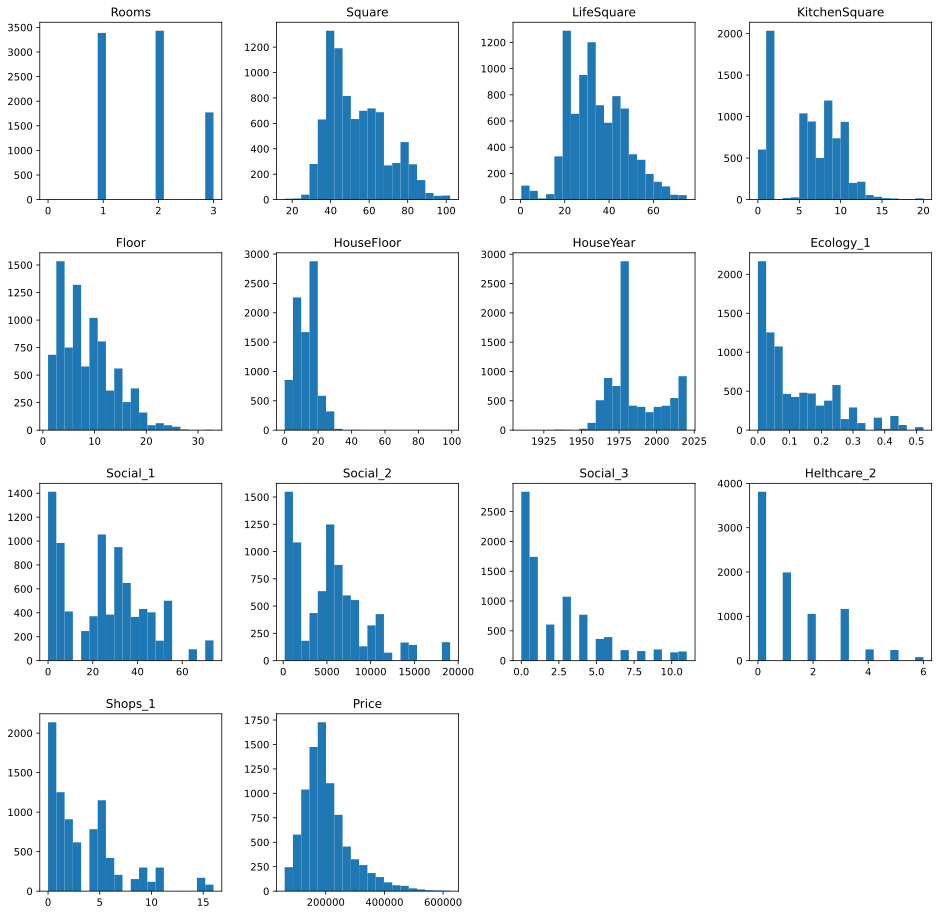

In [757]:
df_num_features.hist(figsize=(16,16), bins=20, grid=False);

In [758]:
# выбросы почищены, сделаем то же самое для тестового датафрейма
# создадим функцию, заменяющую выбросы в выборке на среднее значение по признаку.

def replace_by_IQ(column, df):
    IQ=df[column].describe()['75%']-df[column].describe()['25%']
    low_border=df[column].describe()['25%']-IQ*1.5
    high_border=df[column].describe()['75%']+IQ*1.5
    mean = df[column].mean()
    
    print('For column {}\n\tIQ:\t{}\n\tLOW:\t{}\n\tHIGH:\t{}\n\tMEAN:\t{}'.format(column, IQ, low_border, high_border, mean))

    index_to_replace = df[(df[column]<low_border)|(df[column]>high_border)].index

    df.loc[index_to_replace, column] = mean
    print('In {} row {} was replaced to {}.'.format(index_to_replace.size, column, mean))

In [759]:
# подготовим тренировочные данные

obj_to_bool(obj_features, test)
test.drop(['Healthcare_1'], axis=1, inplace=True)
replace_by_IQ('Square', test)
replace_by_IQ('LifeSquare', test)
fill_life_square(test, square_coeff)
replace_by_IQ('KitchenSquare', test)
replace_by_IQ('Rooms', test)
replace_by_IQ('Social_3', test)

For column Square
	IQ:	24.37889829487171
	LOW:	5.337883253363636
	HIGH:	102.85347643285048
	MEAN:	56.449500363812504
In 110 row Square was replaced to 56.449500363812504.
For column LifeSquare
	IQ:	22.082065205778463
	LOW:	-10.031071759483922
	HIGH:	78.29718906362993
	MEAN:	36.158810455086694
In 118 row LifeSquare was replaced to 36.158810455086694.
For column KitchenSquare
	IQ:	8.0
	LOW:	-11.0
	HIGH:	21.0
	MEAN:	5.9768
In 19 row KitchenSquare was replaced to 5.9768.
For column Rooms
	IQ:	1.0
	LOW:	-0.5
	HIGH:	3.5
	MEAN:	1.91
In 100 row Rooms was replaced to 1.91.
For column Social_3
	IQ:	5.0
	LOW:	-7.5
	HIGH:	12.5
	MEAN:	8.2626
In 446 row Social_3 was replaced to 8.2626.


In [760]:
# проверим что вышло

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     5000 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   bool   
 11  Ecology_3      5000 non-null   bool   
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   float64
 15  Helthcare_2    5000 non-null   int64  
 16  Shops_1        5000 non-null   int64  
 17  Shops_2        5000 non-null   bool   
dtypes: bool(

In [761]:
test_num_features = test.select_dtypes(include=['float64', 'int64'])\
    .drop(['Id', 'DistrictId'], axis=1)

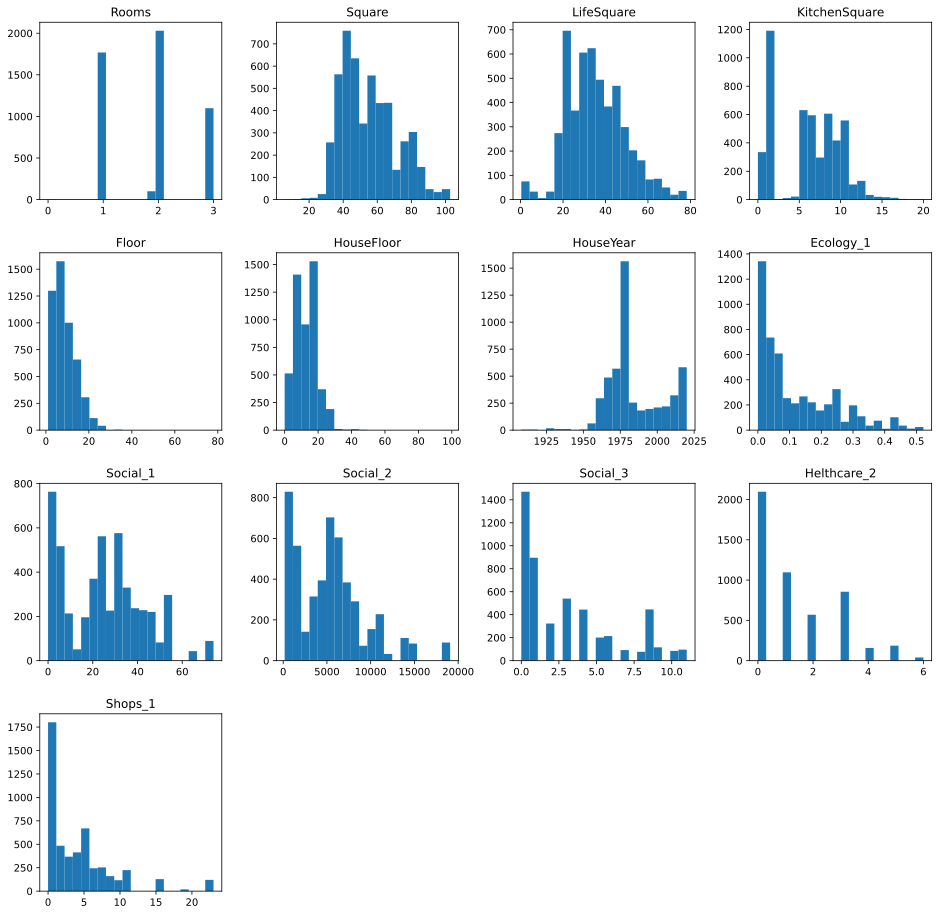

In [762]:
test_num_features.hist(figsize=(16,16), bins=20, grid=False);

In [763]:
# разобьем тестовый датасет на тестовый и валидационный

features = df.columns.drop('Id').drop('DistrictId').drop('Price')
target = 'Price'

In [764]:
X = pd.DataFrame(df, columns=features)
y = pd.DataFrame(df, columns=[target])

In [765]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=21)

In [766]:
X_test = test[features]
X_test.head()

Rooms     Square  LifeSquare  KitchenSquare  Floor  HouseFloor  HouseYear  \
0    2.0  49.882643   33.432782            6.0      6        14.0       1972   
1    2.0  69.263183   46.647965            1.0      6         1.0       1977   
2    1.0  13.597819   15.948246           12.0      2         5.0       1909   
3    2.0  73.046609   51.940842            9.0     22        22.0       2007   
4    1.0  47.527111   43.387569            1.0     17        17.0       2017   

   Ecology_1  Ecology_2  Ecology_3  Social_1  Social_2  Social_3  Helthcare_2  \
0   0.310199      False      False        11      2748    1.0000            0   
1   0.075779      False      False         6      1437    3.0000            0   
2   0.000000      False      False        30      7538    8.2626            5   
3   0.101872      False      False        23      4583    3.0000            3   
4   0.072158      False      False         2       629    1.0000            0   

   Shops_1  Shops_2  
0        0    False  
1        2    False  
2        5    False  
3        3    False  
4        0     True

In [767]:
# масштабируем данные

scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=features)
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid), columns=features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=features)

На тренировочном наборе модели LinearRegression и Decision tree дали примерно одинаковый результат. Наилучший результат был получен на модели RandomForestRegressor с параметрами n_estimators=100, max_depth=15, random_state=99

In [768]:
def fit_pred(x_train, y_train, x_test, y_test, model):
    model.fit(x_train, y_train)
    
    y_train_pred = model.predict(x_train) 
    y_test_pred = model.predict(x_test)
    
    r2_train = r2_score(y_train, y_train_pred)
    mae_train = mae(y_train, y_train_pred)
    print(f'r2_train = {r2_train}, mae_train: {mae_train}')
    
    r2_test = r2_score(y_test, y_test_pred)
    mae_test = mae(y_test, y_test_pred)
    print(f'r2_test = {r2_test}, mae_test: {mae_test}')

In [769]:
model = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=21)
fit_pred(X_train_scaled, y_train, X_valid_scaled, y_valid, model)

r2_train = 0.9453276116641133, mae_train: 12380.683988962091
r2_test = 0.724508245332287, mae_test: 25075.49893775115


In [770]:
# предсказываем цены для тестового датасета и выгружаем результат в файл.

price = model.predict(X_test_scaled)
pd.DataFrame({ 'Id': test['Id'], 'Price': price }).to_csv('EShchukin_predictions.csv', index=False)